시각화는 프론트엔지니어가 붙습니다.
통합 관리로 빅데이터 플랫폼을 관리하기위한 시스템엔지니어, 서버엔지니어가 붙습니다.

제가 담당하는 시스템은 일데이터 100~200G 이상 총 데이터는 1.5~2P(페타)급 데이터를 관리하고 있습니다. 
현직에서 사용하는 기술이나 툴을 빠꾸없이 말씀드리면 
수집은 배치수집, 실시간수집을 주로하며 실시간은 kafka-nifi 씁니다. 배치도 nifi통해서 ftp to hdfs, db to hdfs, api to hdfs 주로 씁니다.(흔히 말하는 데이터 파이프라인이 이런거라 보면 됩니다)
데이터레이크는 hive-meta 기반 kudu저장소나 hive-hdfs 저장소를 씁니다.(external,과 managed구분) 대용량 단일테이블은 hbase도 일부 사용합니다.
쿼리엔진은 impala씁니다. (impala-hive, impala-kudu)
분석은 spark 위에서 pyspark나 sparklyr 쓰는데 보통은 pyspark씁니다.(분석기법이나 알고리즘은 저는 모릅니다)
시각화는 개발이나 상용솔루션 사용하기 나름 입니다.

저의 직무는 파이프라인 개발 및 운영, 하둡 및 서버엔지니어링(리눅스 고급튜닝, 다중서버관리)를 하고 있습니다.
관리하는 노드는 수집노드(nifi cluster) 5대 하둡-관리노드 7대 하둡-데이터노드 400대정도 관리하고있으며 private network 40G l2 스위치, Service network 1G l3스위치 사용하고 있습니다.
분석을위한 gpu 서버는 24베이 GPU서버를 두대 구축하여 nividia-docker기반으로 관리중이고 분석작업시 데이터노드가 docker로 nvidia gpu를 불러 사용중입니다. 
외부연계를 위한 dmz구간 gw서버는 두대 사용중이며 이중화구성을 위해 haproxy 로드밸런싱을 위해 pcs cluster로 구축했습니다.

다중서버관리로는 ansible-playbook 기반으로 스크립트짜서 관리하고 있습니다.

In [1]:
# 가설!!
# K - Beauty는 성장하고 있을까? 해외 직접판매를 한다면 어느 국가로 판매전략을 세우면 좋을까?

# 라이브러리 로드
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 코랩에서는 이렇게 설정해줘야 그래프 표시가 가능!
%matplotlib inline 

In [2]:
# 한글폰트를 설정해 주지 않으면 그래프 상에서 한글이 깨져보인다.
# 한글이 출력될 수 있도록 폰트 설정
import os

# 윈도우, 맥 외의 os느 별도로 설정해 주어야함
if os.name == 'posix' : # 포직스면 맥임.
  plt.rc('font', family='AppleGothic')
else:
  plt.rc('font', family='Malgun Gothic') # 윈도우일 경우
# 마이너스 폰트 깨지는 문제에 대한 대처
plt.rc('axes', unicode_minus=False)

In [3]:
# 한글폰트 깨지는거 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,332 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [4]:
# 레티나 설정을 해주면 글씨가 좀더 선명하게 보임
%config InlineBackend.figure_format = 'retina'

In [5]:
# 데이터 로드하기
from google.colab import drive
drive.mount('/content/working_drive')

import os

working_dir = 'datasets'

colab_default_dir = '/content/working_drive/MyDrive/Colab Notebooks/BT/파이썬으로 시작하는 데이터분석 코스/'

original_dir = os.getcwd() # save current dir

try :
  os.chdir(colab_default_dir)
  if not os.path.exists(working_dir):
    os.mkdir(working_dir)

  os.chdir(working_dir) # change working dir
  print('current dir =', os.getcwd())

except Exception as err:

  os.chdir(original_dir)
  print(str(err))

Mounted at /content/working_drive
current dir = /content/working_drive/My Drive/Colab Notebooks/BT/data


In [ ]:
df_raw = pd.read_csv('국가_대륙_별_상품군별_온라인쇼핑_해외직접판매액_20210424151113.csv', low_memory=False, encoding='cp949') 
df_raw.shape

(450, 31)

In [ ]:
# '국가(대륙)별' 데이터 빈도수 세기
df_raw['국가(대륙)별'].value_counts()

중남미           45
유럽연합(EU)      45
기타            45
대양주           45
미국            45
중국            45
아세안(ASEAN)    45
일본            45
중동            45
합계            45
Name: 국가(대륙)별, dtype: int64

In [ ]:
df_raw[df_raw['국가(대륙)별'] == '미국']

,국가(대륙)별,상품군별,판매유형별,2014 1/4,2014 2/4,2014 3/4,2014 4/4,2015 1/4,2015 2/4,2015 3/4,2015 4/4,2016 1/4,2016 2/4,2016 3/4,2016 4/4,2017 1/4,2017 2/4,2017 3/4,2017 4/4,2018 1/4,2018 2/4,2018 3/4,2018 4/4,2019 1/4,2019 2/4,2019 3/4,2019 4/4,2020 1/4,2020 2/4,2020 3/4,2020 4/4 p)
45,미국,합계,계,25773,22573,21288,26729,39945,26654,28647,37392,38179,36831,35290,44421,45169,40976,41927,53209,42679,40207,37631,48978,40918,44861,55386,53848,48277,64225,54990,67535
46,미국,합계,면세점,-,-,-,-,-,-,-,-,-,-,-,-,8160,9183,9469,12177,5184,3603,2317,2079,2657,2951,1818,1481,698,339,81,67
47,미국,합계,면세점 이외,-,-,-,-,-,-,-,-,-,-,-,-,37009,31793,32458,41032,37495,36604,35314,46899,38261,41910,53568,52367,47579,63886,54909,67468
48,미국,컴퓨터 및 주변기기,계,2216,1666,1776,1675,1469,1393,2166,2362,2533,2121,1704,1531,1054,946,791,854,2033,1553,1784,1774,1298,1408,1653,1382,1182,1630,1923,1386
49,미국,컴퓨터 및 주변기기,면세점,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
50,미국,컴퓨터 및 주변기기,면세점 이외,-,-,-,-,-,-,-,-,-,-,-,-,1054,946,791,854,2033,1553,1784,1773,1298,1408,1653,1382,1182,1630,1923,1386
51,미국,가전·전자·통신기기,계,2875,2758,2894,3527,4397,3589,2982,3286,3571,2921,2744,3354,2730,2425,2575,2394,1737,1716,1723,1886,1845,1837,3166,1785,1830,2824,3286,2178
52,미국,가전·전자·통신기기,면세점,-,-,-,-,-,-,-,-,-,-,-,-,18,23,29,32,65,38,72,52,66,116,107,49,12,2,5,1
53,미국,가전·전자·통신기기,면세점 이외,-,-,-,-,-,-,-,-,-,-,-,-,2712,2402,2546,2362,1672,1678,1651,1834,1779,1721,3059,1736,1818,2822,3281,2177
54,미국,소프트웨어,계,47,57,49,128,182,113,163,116,147,103,82,83,67,45,37,125,175,251,172,269,88,156,118,338,135,182,137,314


In [ ]:
# 분석과 시각화를 위한 tidy data 만들기!
# column부분의 분기별 데이터를 하나의 행으로 만들어주기위해 melt 사용
df = df_raw.melt(id_vars=['국가(대륙)별', '상품군별', '판매유형별'], var_name='기간', value_name='백만원')
df.shape

(12600, 5)

In [ ]:
df.head()

,국가(대륙)별,상품군별,판매유형별,기간,백만원
0,합계,합계,계,2014 1/4,148272
1,합계,합계,면세점,2014 1/4,-
2,합계,합계,면세점 이외,2014 1/4,-
3,합계,컴퓨터 및 주변기기,계,2014 1/4,4915
4,합계,컴퓨터 및 주변기기,면세점,2014 1/4,-


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   국가(대륙)별  12600 non-null  object
 1   상품군별     12600 non-null  object
 2   판매유형별    12600 non-null  object
 3   기간       12600 non-null  object
 4   백만원      12600 non-null  object
dtypes: object(5)
memory usage: 492.3+ KB


In [ ]:
'2020 1/4 p)'.split()[1].split('/')[0]

'1'

In [ ]:
df['연도'] = df['기간'].map(lambda x : int(x.split()[0]))
df.head()

,국가(대륙)별,상품군별,판매유형별,기간,백만원,연도
0,합계,합계,계,2014 1/4,148272,2014
1,합계,합계,면세점,2014 1/4,-,2014
2,합계,합계,면세점 이외,2014 1/4,-,2014
3,합계,컴퓨터 및 주변기기,계,2014 1/4,4915,2014
4,합계,컴퓨터 및 주변기기,면세점,2014 1/4,-,2014


In [ ]:
df['분기'] = df['기간'].map(lambda x : int(x.split()[1].split('/')[0]))
df.head()

,국가(대륙)별,상품군별,판매유형별,기간,백만원,연도,분기
0,합계,합계,계,2014 1/4,148272,2014,1
1,합계,합계,면세점,2014 1/4,-,2014,1
2,합계,합계,면세점 이외,2014 1/4,-,2014,1
3,합계,컴퓨터 및 주변기기,계,2014 1/4,4915,2014,1
4,합계,컴퓨터 및 주변기기,면세점,2014 1/4,-,2014,1


In [ ]:
# 금액을 수치데이터로 표현하기 위해 데이터 타입 변경하기
# - 문자를 결측치로 만들어주고 결측치를 채우거나 지워줌
df['백만원'] = df['백만원'].replace('-', pd.np.nan).astype(float)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until


,국가(대륙)별,상품군별,판매유형별,기간,백만원,연도,분기
0,합계,합계,계,2014 1/4,148272.0,2014,1
1,합계,합계,면세점,2014 1/4,NaN,2014,1
2,합계,합계,면세점 이외,2014 1/4,NaN,2014,1
3,합계,컴퓨터 및 주변기기,계,2014 1/4,4915.0,2014,1
4,합계,컴퓨터 및 주변기기,면세점,2014 1/4,NaN,2014,1


In [ ]:
# 필요없는 데이터 제거하기
# 합계데이터가 쓸모없으니 지운다.
df = df[(df['국가(대륙)별'] != '합계') & (df['상품군별'] != '합계')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10584 entries, 48 to 12599
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   국가(대륙)별  10584 non-null  object 
 1   상품군별     10584 non-null  object 
 2   판매유형별    10584 non-null  object 
 3   기간       10584 non-null  object 
 4   백만원      7560 non-null   float64
 5   연도       10584 non-null  int64  
 6   분기       10584 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 661.5+ KB


In [ ]:
# 결측치 보기
df.isnull().sum()

국가(대륙)별       0
상품군별          0
판매유형별         0
기간            0
백만원        3024
연도            0
분기            0
dtype: int64

In [ ]:
# K-Beauty 시각화

df_total = df[df['판매유형별'] == '계'].copy()
df_total.head()

,국가(대륙)별,상품군별,판매유형별,기간,백만원,연도,분기
48,미국,컴퓨터 및 주변기기,계,2014 1/4,2216.0,2014,1
51,미국,가전·전자·통신기기,계,2014 1/4,2875.0,2014,1
54,미국,소프트웨어,계,2014 1/4,47.0,2014,1
57,미국,서 적,계,2014 1/4,962.0,2014,1
60,미국,사무·문구,계,2014 1/4,25.0,2014,1


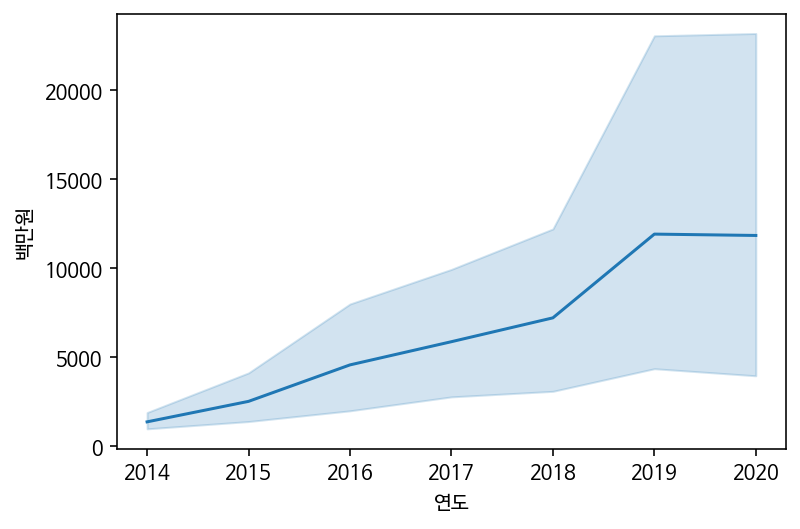

In [ ]:
# 연도, 판매액을 lineplot으로 그리기
sns.lineplot(data=df_total, x='연도', y='백만원')

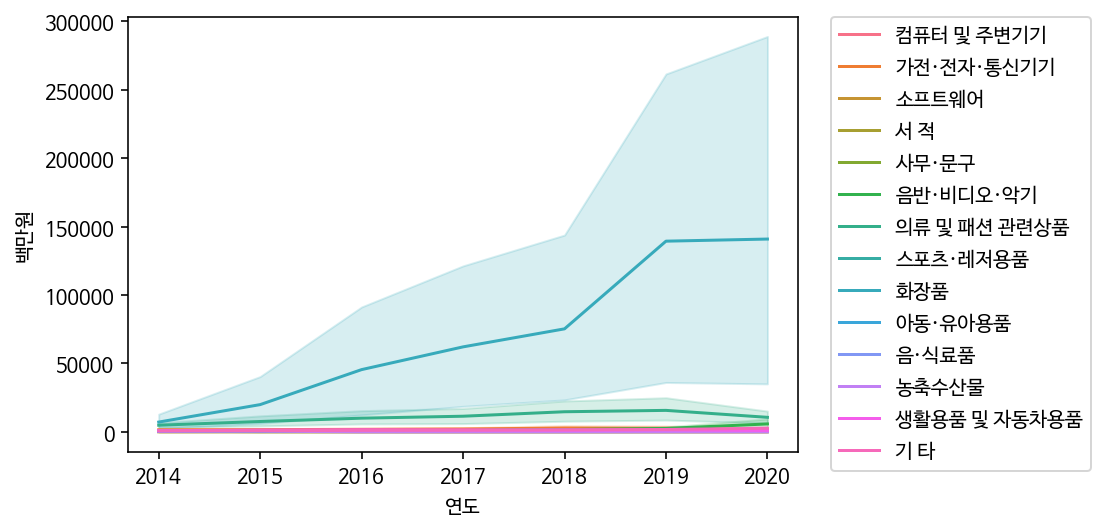

In [ ]:
sns.lineplot(data=df_total, x='연도', y='백만원', hue='상품군별')
# legend가 그래프와 겹쳐서 밖으로 표현하는법
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

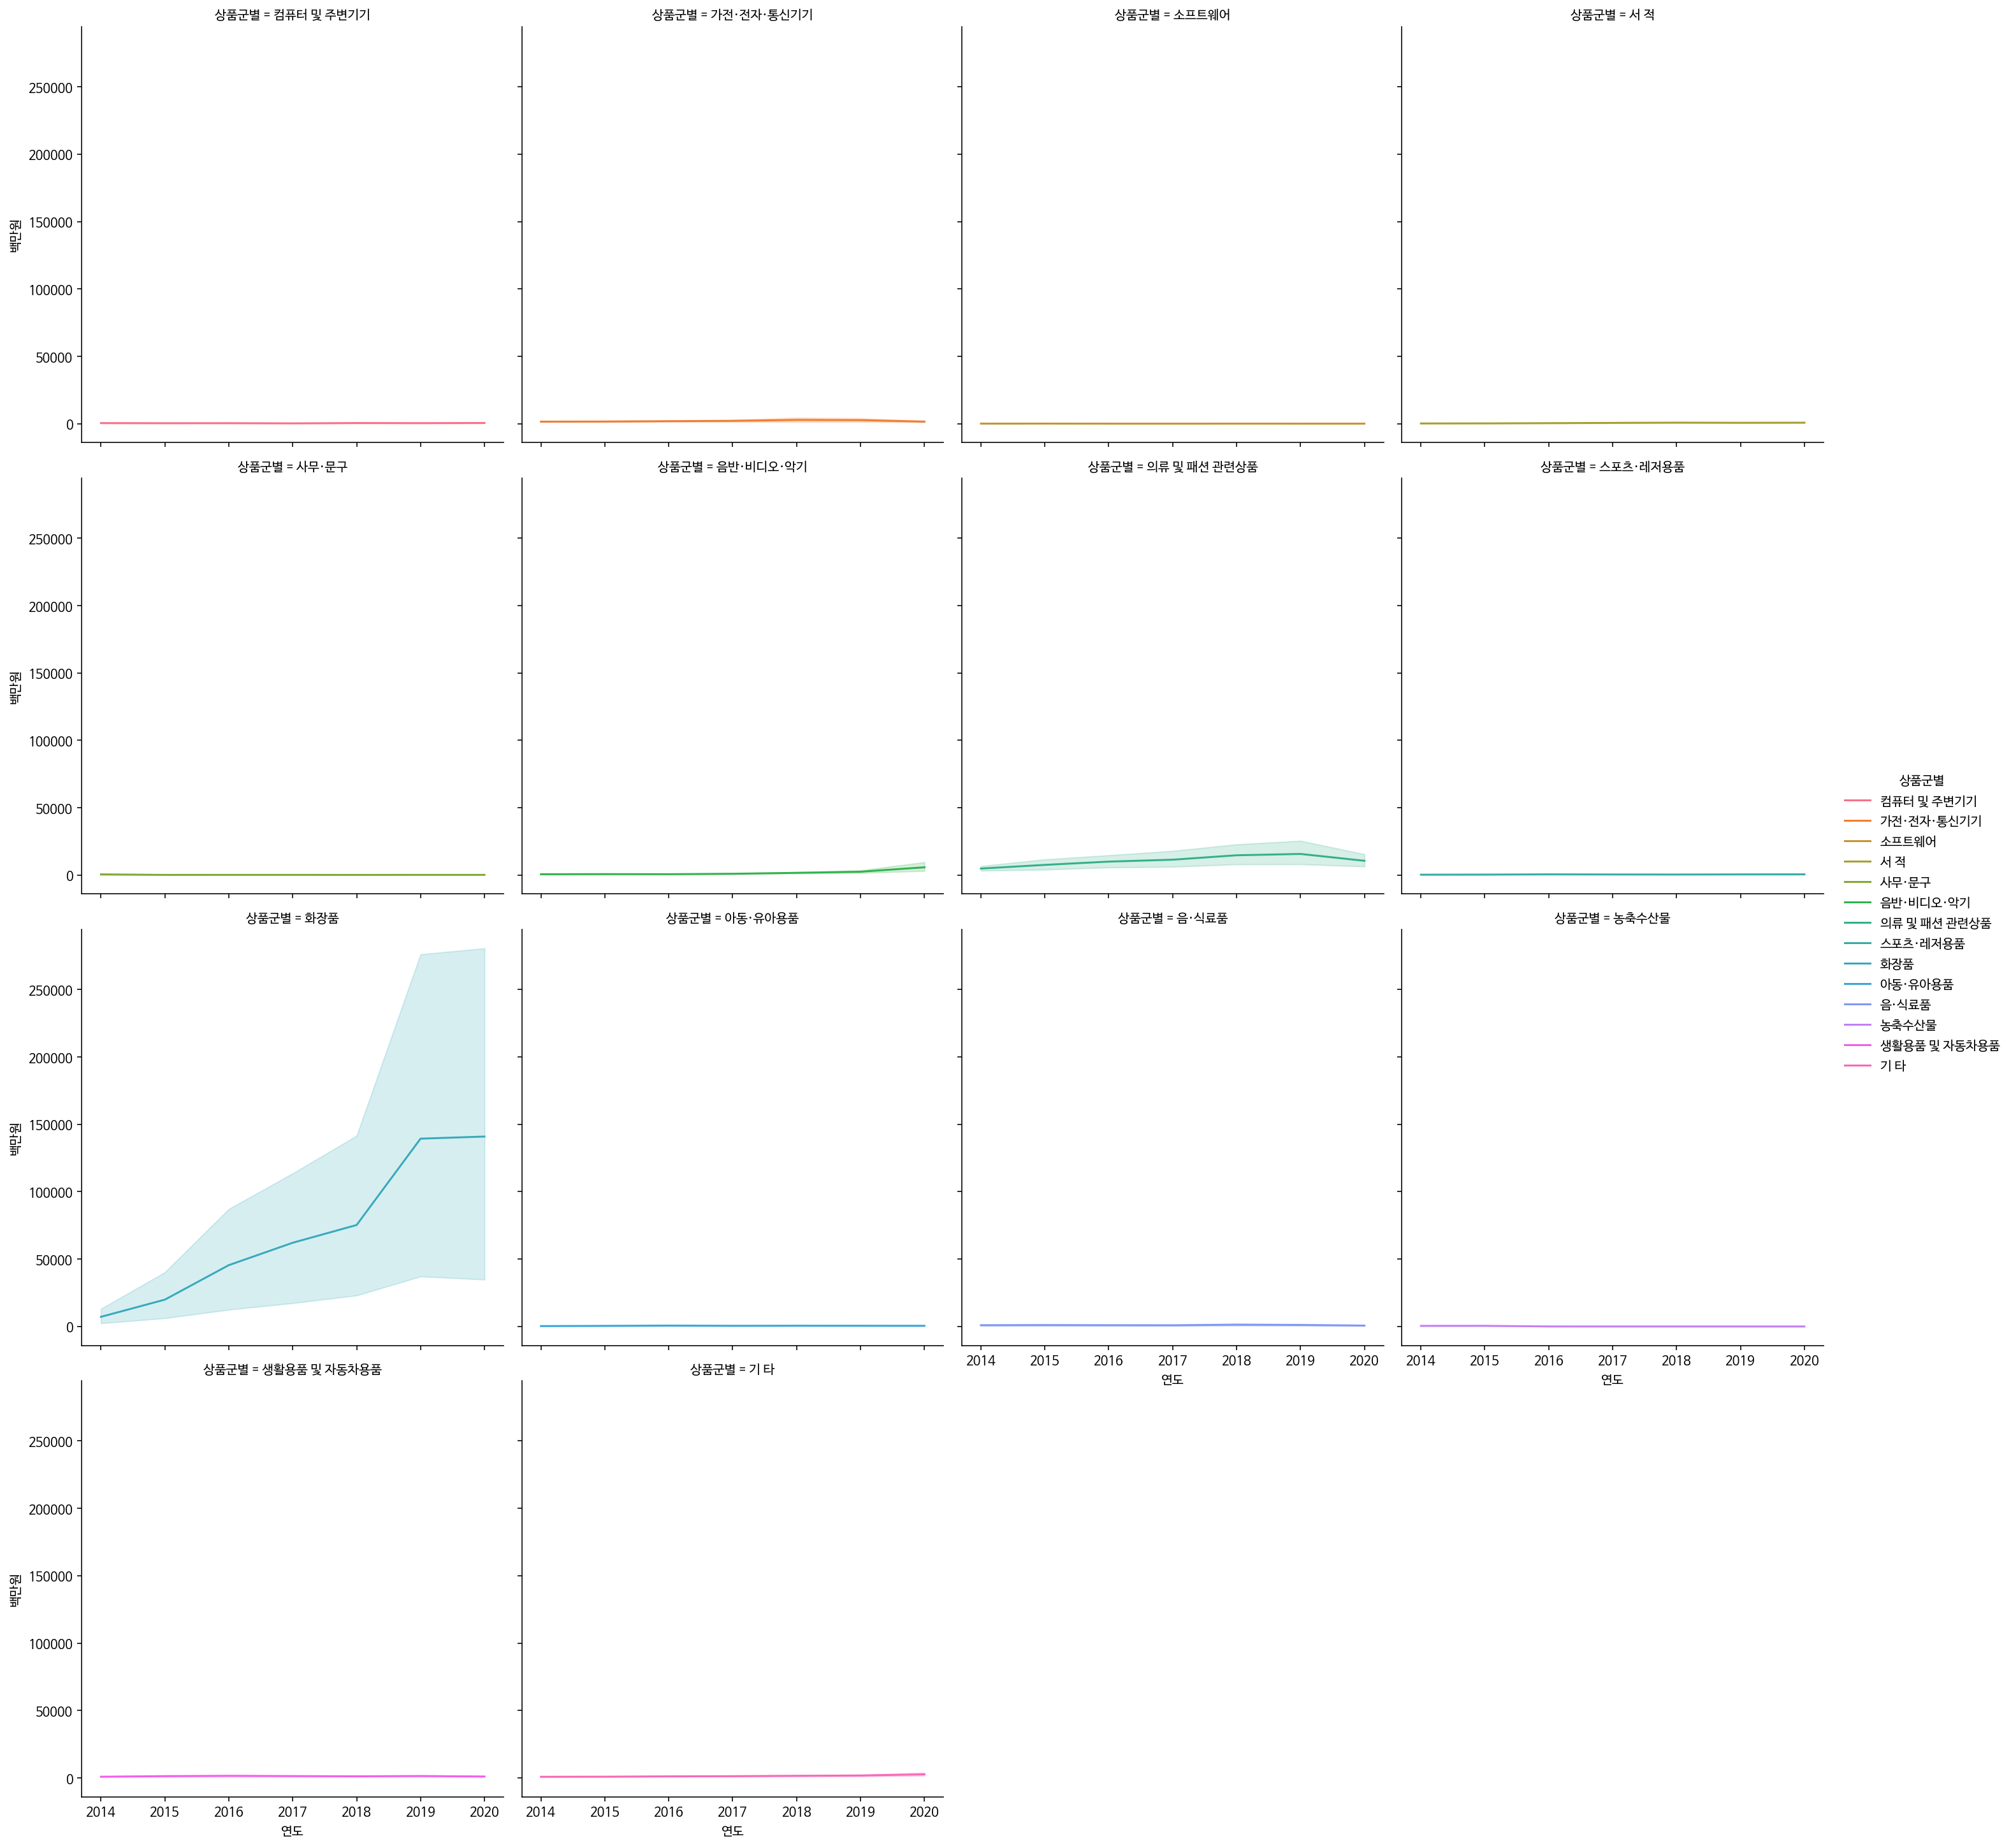

In [ ]:
# relplot은 lineplot을 서브플롯으로 그릴 수 있다.
# 같은데 relplot을 그리는 이유는?? option에 col='상품군별', col_wrap=4 를 표시하면 상품군별에 따라 그래프를 그릴 수 있다.
sns.relplot(data=df_total, x='연도', y='백만원', hue ='상품군별', kind='line',col='상품군별', col_wrap=4)

In [ ]:
# isin을 통해 나머지를 제외한 화장품군 데이터만 가져올 수 있다.
df_sub = df_total[-df_total['상품군별'].isin(['화장품','의류 및 패션관련 상품'])].copy()

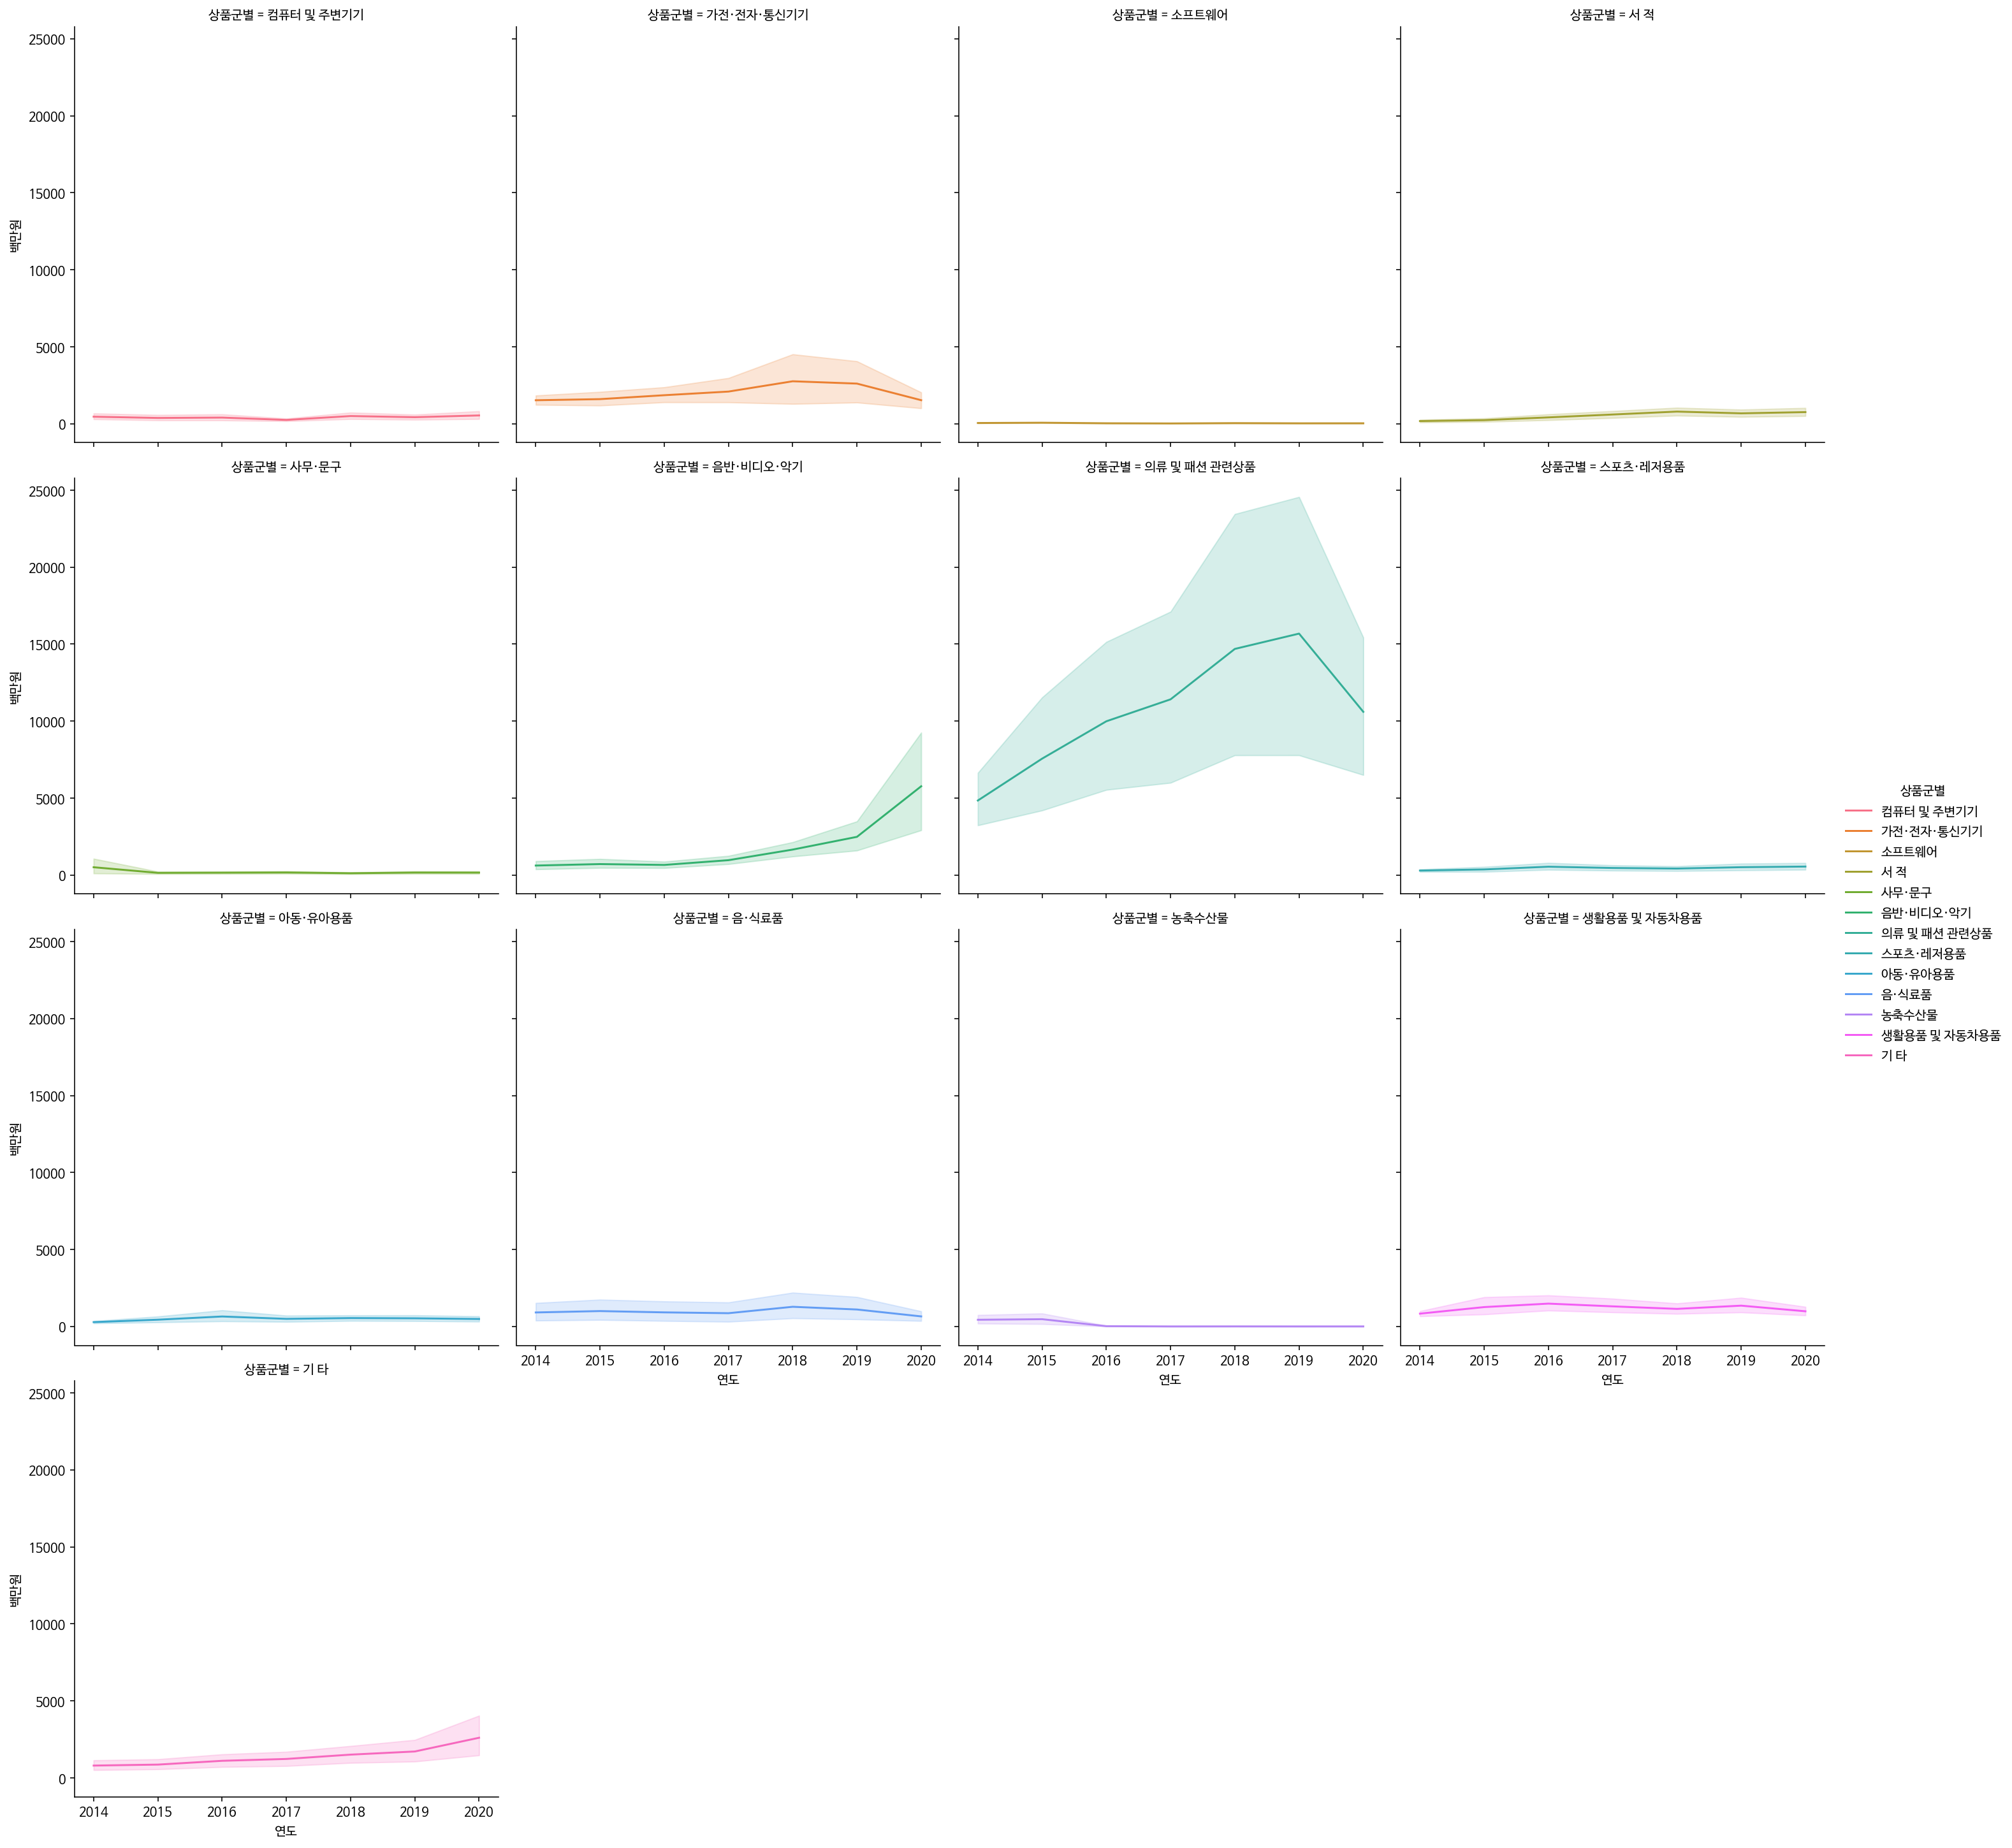

In [ ]:
sns.relplot(data=df_sub, x='연도', y='백만원', hue='상품군별',kind= 'line',col='상품군별', col_wrap=4)
# 화장품을 빼고보니 나머지 품목들의 상승 하락세를 볼 수 있다.
# 사실은 의류 및 패션관련 상품도 그래프 폭이 커서 나머지들의 구별이 쉽지 않은데 현재 데이터 전처리가 제대로
# 이루어져 있지 않아 y=0의 직선형태를 띈다.

In [ ]:
df_cosmetic = df_total[df_total['상품군별']=='화장품'].copy()
df_cosmetic['상품군별'].unique()

array(['화장품'], dtype=object)

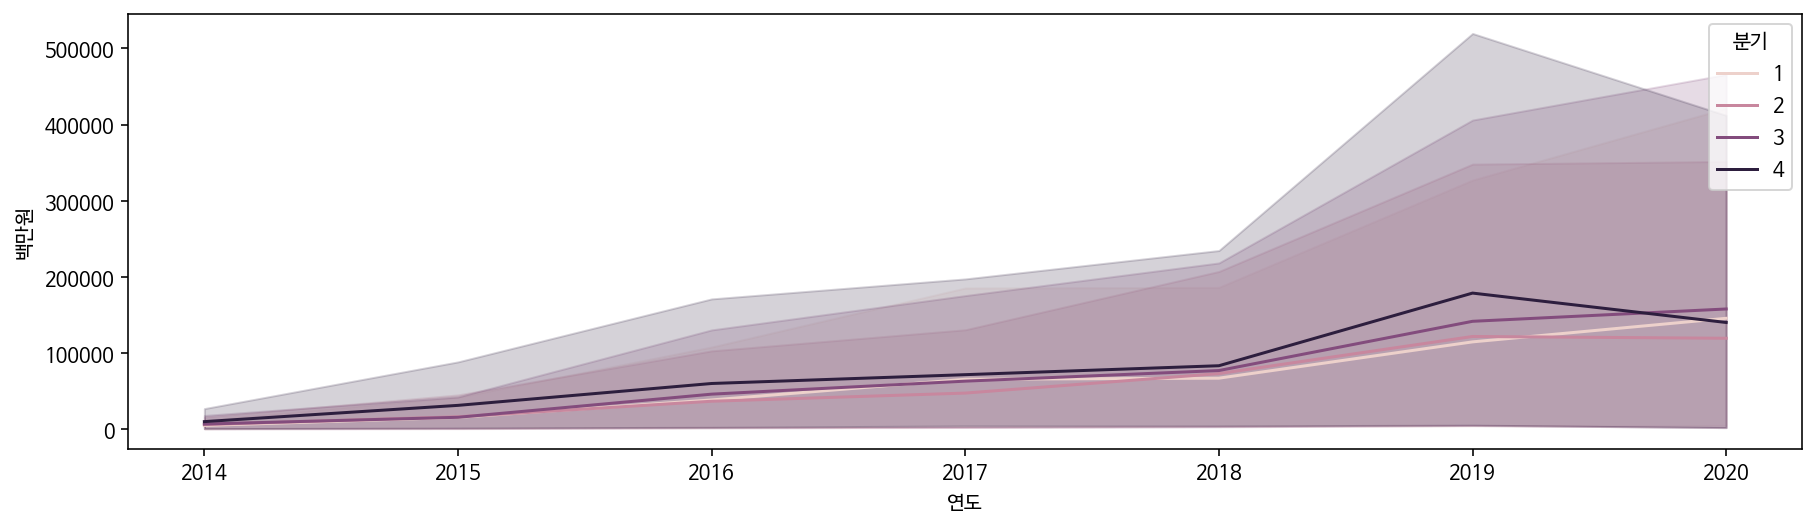

In [ ]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df_cosmetic, x='연도', y='백만원', hue='분기')

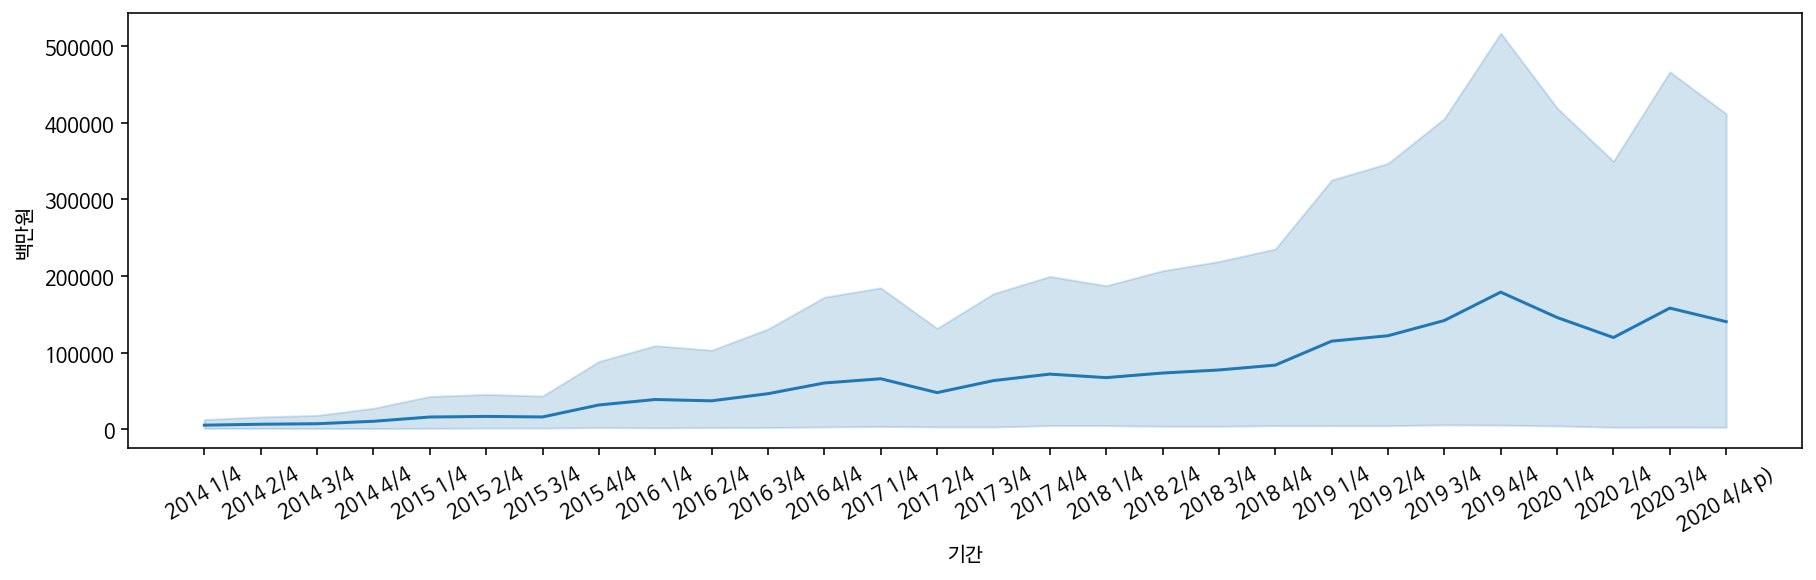

In [ ]:
# 화장품 판매액에 대한 기간별 금액 데이터 시각화
plt.figure(figsize=(15,4))
plt.xticks(rotation=30)
sns.lineplot(data=df_cosmetic, x='기간', y='백만원')

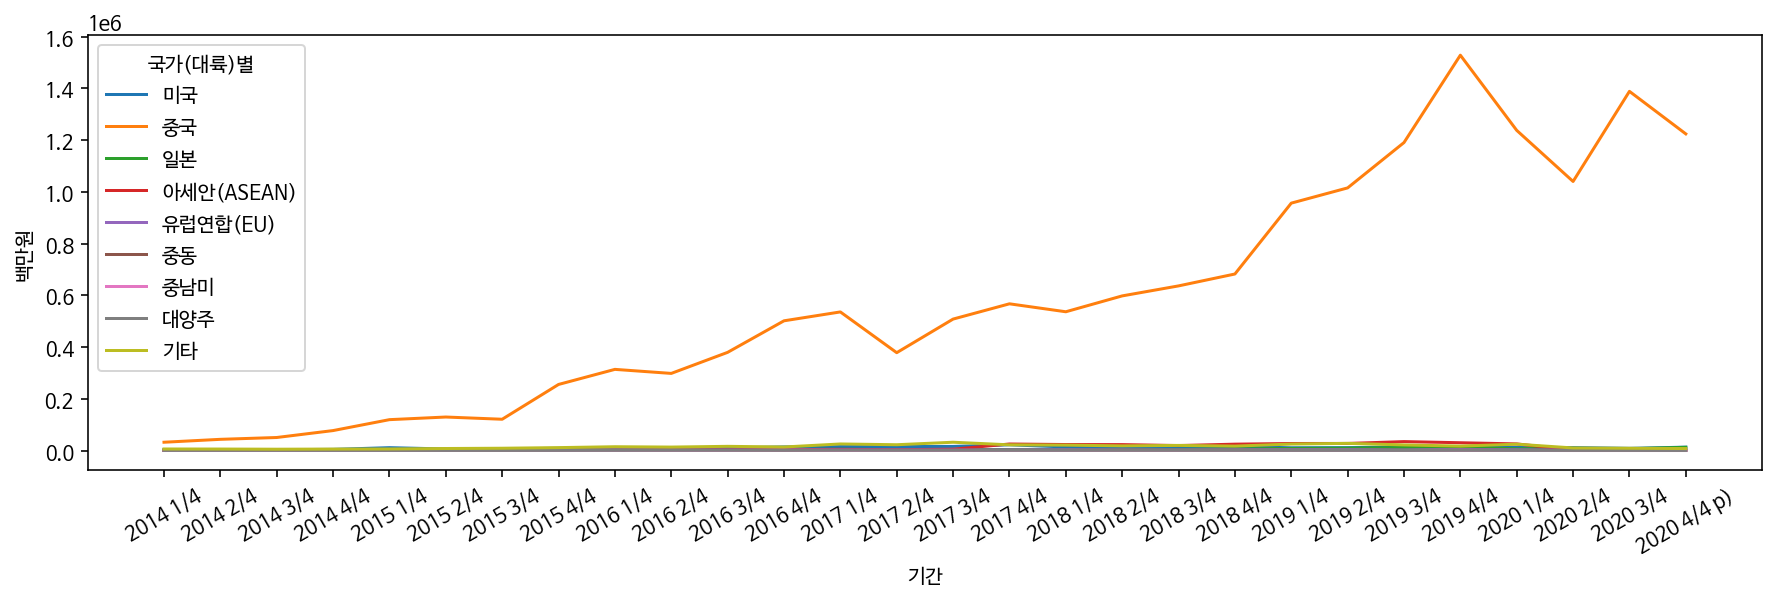

In [ ]:
plt.figure(figsize=(15,4))
plt.xticks(rotation=30)
sns.lineplot(data=df_cosmetic, x='기간', y='백만원',hue='국가(대륙)별')

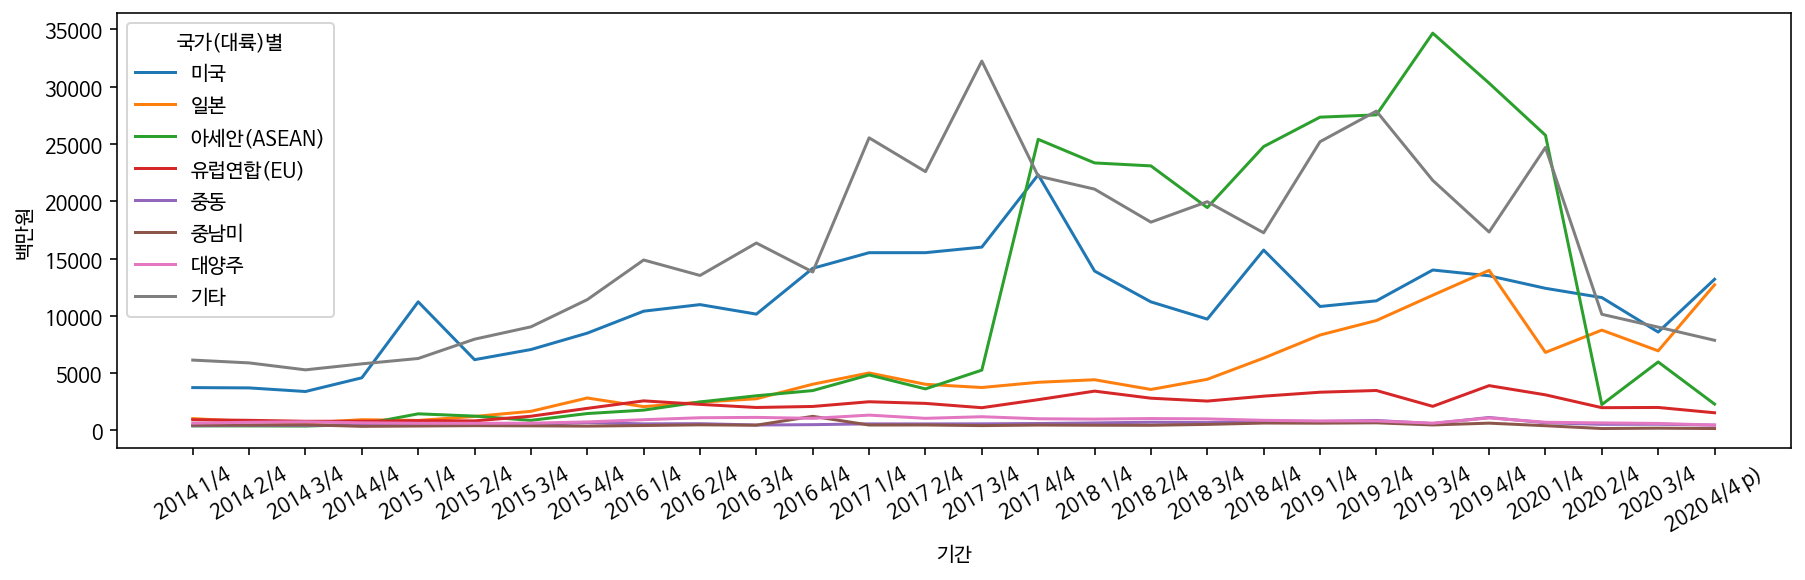

In [ ]:
# 중국 이외의 나라의 수출 순위를 보기위해 분류
plt.figure(figsize=(15,4))
plt.xticks(rotation=30)
sns.lineplot(data=df_cosmetic[df_cosmetic['국가(대륙)별'] != '중국'], x='기간', y='백만원',hue='국가(대륙)별')

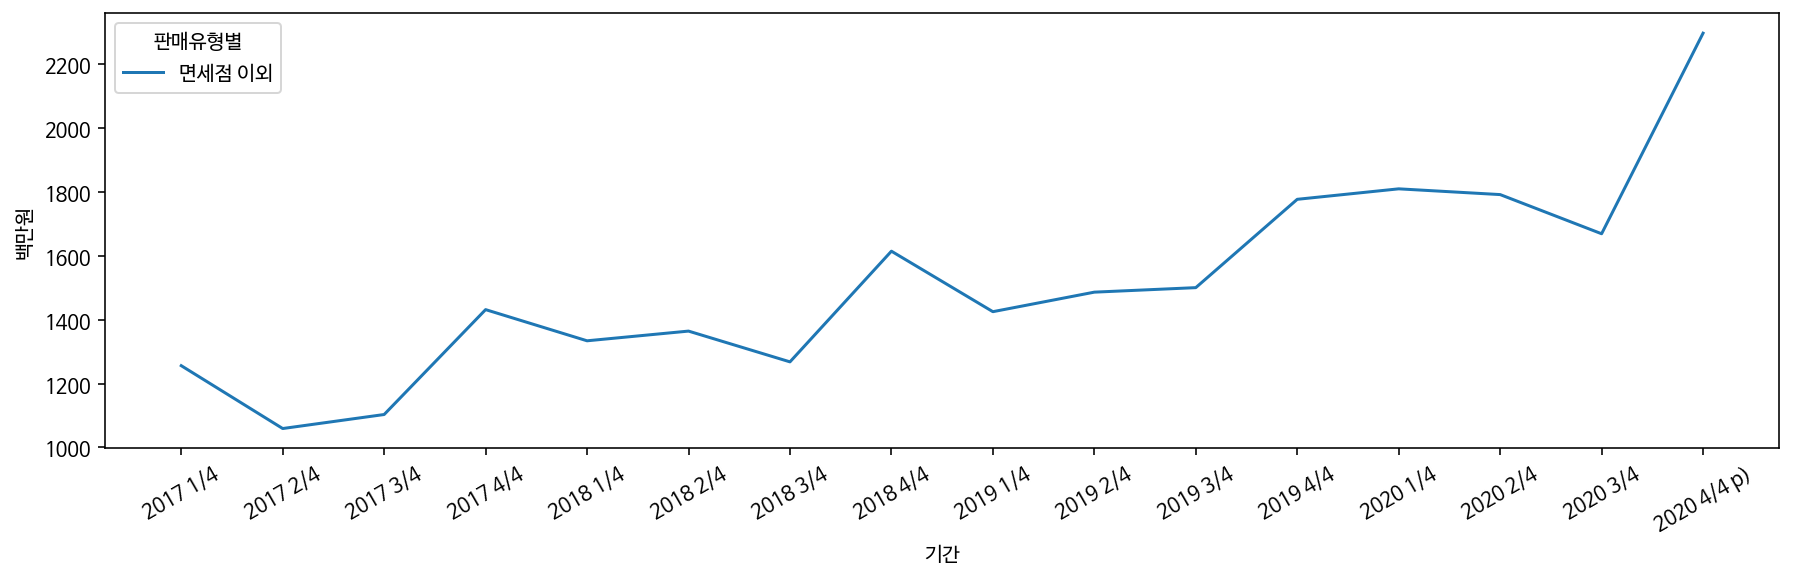

In [ ]:
plt.figure(figsize=(15,4))
plt.xticks(rotation=30)
df_sub = df[(df['판매유형별'] != '계') & (df['판매유형별'] != '면세점')].copy()
sns.lineplot(data=df_sub, x='기간', y='백만원', hue='판매유형별', ci=None)
# 면세점과 면세점 외에도 온라인 판매액은 꾸준히 증가하고 있음을 볼 수 있다.

In [ ]:
# 의류 및 패션관령 상품 온라인쇼핑 해외직접 판매액

df_fashion = df[(df['상품군별'] == '의류 및 패션 관련상품') & (df['판매유형별'] == '계')].copy()
df_fashion.head()

,국가(대륙)별,상품군별,판매유형별,기간,백만원,연도,분기
66,미국,의류 및 패션 관련상품,계,2014 1/4,9810.0,2014,1
111,중국,의류 및 패션 관련상품,계,2014 1/4,12206.0,2014,1
156,일본,의류 및 패션 관련상품,계,2014 1/4,13534.0,2014,1
201,아세안(ASEAN),의류 및 패션 관련상품,계,2014 1/4,3473.0,2014,1
246,유럽연합(EU),의류 및 패션 관련상품,계,2014 1/4,1364.0,2014,1


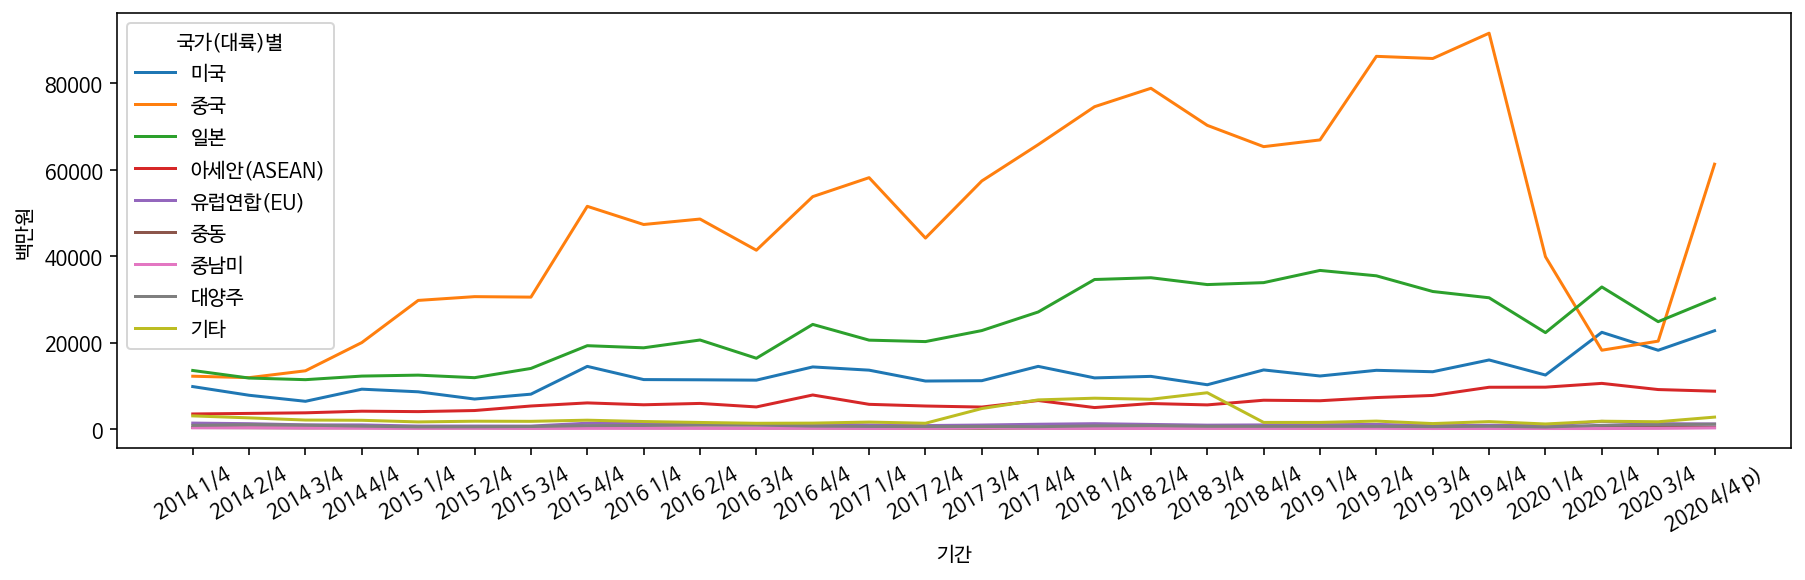

In [ ]:
# 기간별 금액 데이터를 시각화
plt.figure(figsize=(15,4))
plt.xticks(rotation=30)
sns.lineplot(data=df_fashion, x='기간', y='백만원', hue='국가(대륙)별')
# 꾸준히 늘어남을 볼수 있다.

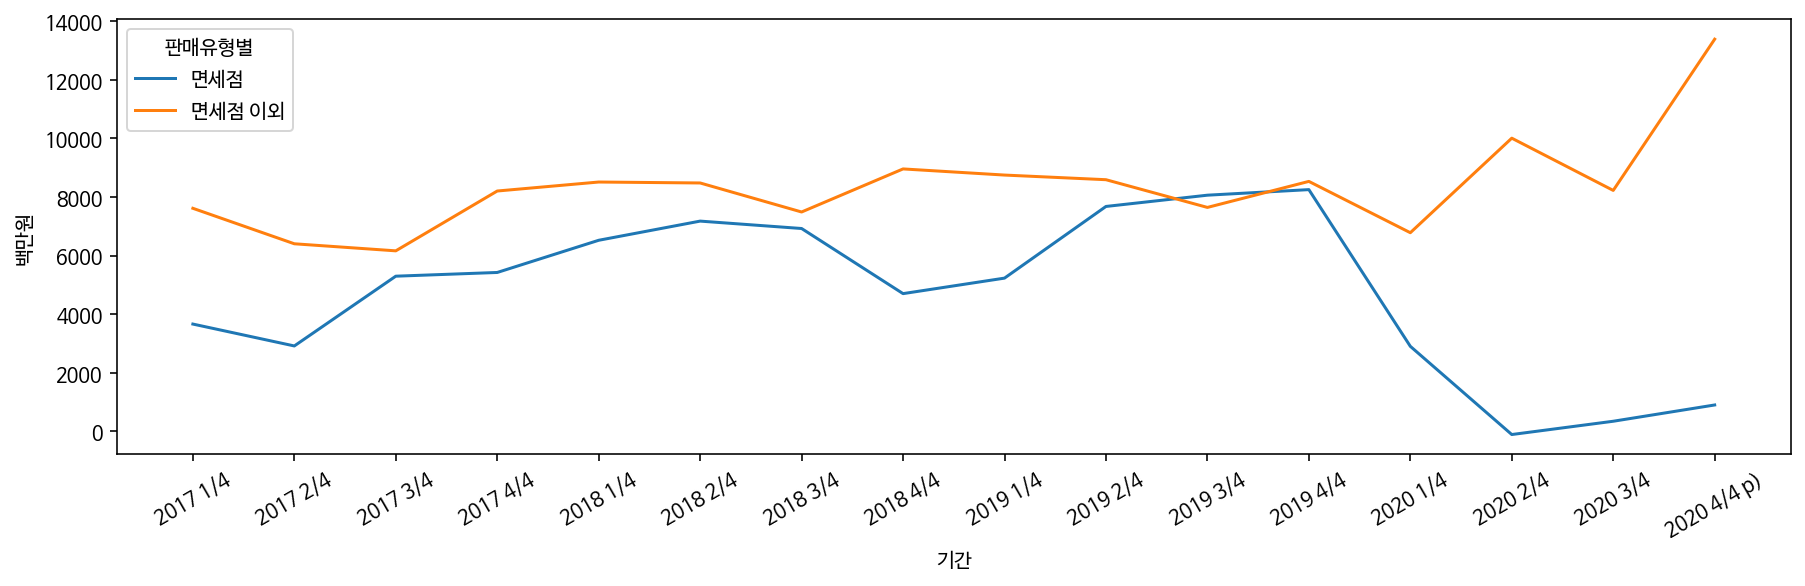

In [ ]:
df_fashion2 = df[(df['상품군별'] == '의류 및 패션 관련상품') & (df['판매유형별'] != '계')].copy()

plt.figure(figsize=(15,4))
plt.xticks(rotation=30)
sns.lineplot(data=df_fashion2, x='기간', y='백만원', hue='판매유형별', ci=None)
# 면세점이 2020 코로나에 타격을 크게 받은걸 볼 수 있다.

In [ ]:
df_fashion.head(2)

,국가(대륙)별,상품군별,판매유형별,기간,백만원,연도,분기
66,미국,의류 및 패션 관련상품,계,2014 1/4,9810.0,2014,1
111,중국,의류 및 패션 관련상품,계,2014 1/4,12206.0,2014,1


In [ ]:
# 데이터 집계하기

result = df_fashion.pivot_table(index='국가(대륙)별', columns='연도',
                       values='백만원', aggfunc='sum') 
# agg function은 디폴트값이 mean
result

연도,2014,2015,2016,2017,2018,2019,2020
국가(대륙)별,,,,,,,
기타,9683.0,7248.0,5918.0,14387.0,23901.0,6309.0,7386.0
대양주,3392.0,2349.0,3401.0,2266.0,2725.0,2387.0,3414.0
미국,33223.0,38066.0,48451.0,50353.0,47875.0,55035.0,75778.0
아세안(ASEAN),14936.0,19639.0,24478.0,22671.0,23068.0,31217.0,38088.0
유럽연합(EU),4485.0,3374.0,4899.0,3736.0,4114.0,3694.0,4978.0
일본,48960.0,57594.0,79905.0,90584.0,136800.0,134243.0,110129.0
중국,57531.0,142339.0,190932.0,225407.0,288848.0,330254.0,139624.0
중남미,975.0,616.0,649.0,762.0,576.0,543.0,610.0
중동,1172.0,1018.0,968.0,772.0,879.0,924.0,1727.0


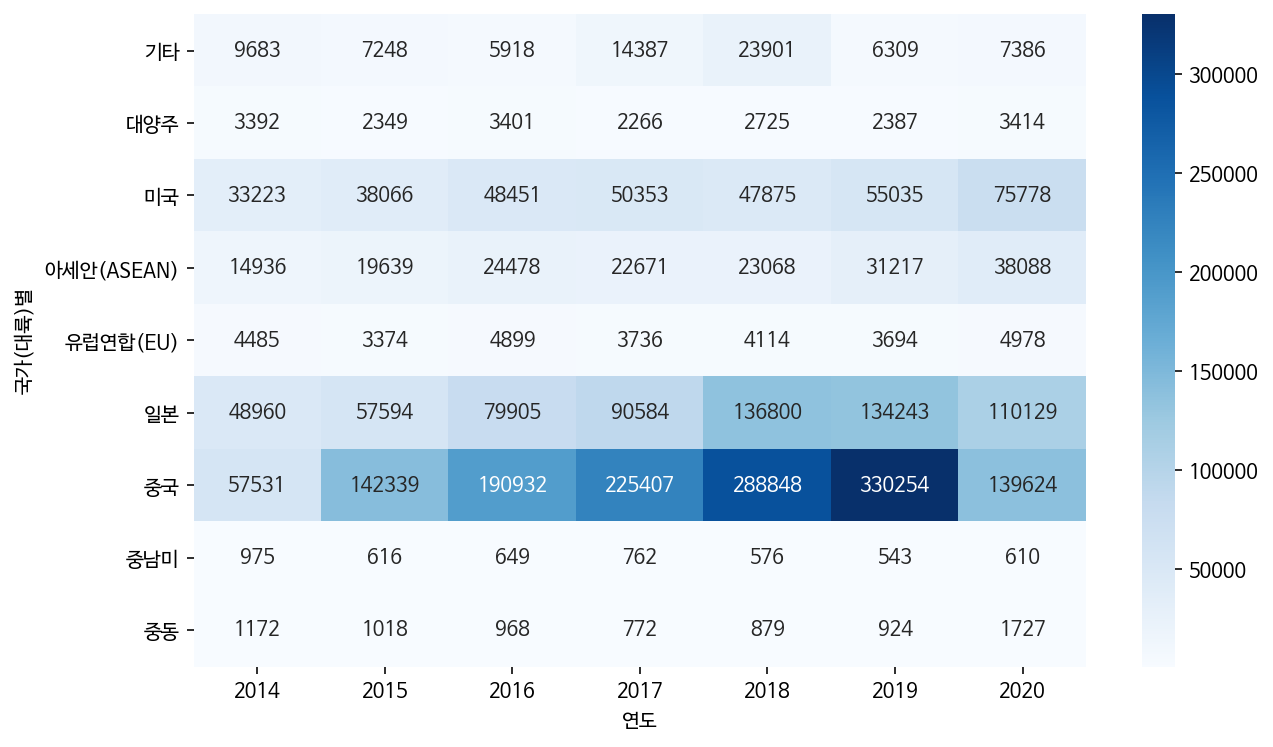

In [ ]:
# 한가지 색상으로보기위해 cmap 사용, 수치를 표현하기위해 annot을 사용
plt.figure(figsize=(10,6))
sns.heatmap(result, cmap='Blues', annot=True, fmt='.0f')
# 중국이 압도적으로 높음을 볼 수 있다. 일본,미국도 증가추세임을 볼 수 있다.

In [ ]:
# 전체 상품군별로 온라인쇼핑 해외직접판매액은 증가했을까??

df_total

,국가(대륙)별,상품군별,판매유형별,기간,백만원,연도,분기
48,미국,컴퓨터 및 주변기기,계,2014 1/4,2216.0,2014,1
51,미국,가전·전자·통신기기,계,2014 1/4,2875.0,2014,1
54,미국,소프트웨어,계,2014 1/4,47.0,2014,1
57,미국,서 적,계,2014 1/4,962.0,2014,1
60,미국,사무·문구,계,2014 1/4,25.0,2014,1
...,...,...,...,...,...,...,...
12585,기타,아동·유아용품,계,2020 4/4 p),588.0,2020,4
12588,기타,음·식료품,계,2020 4/4 p),92.0,2020,4
12591,기타,농축수산물,계,2020 4/4 p),3.0,2020,4
12594,기타,생활용품 및 자동차용품,계,2020 4/4 p),391.0,2020,4


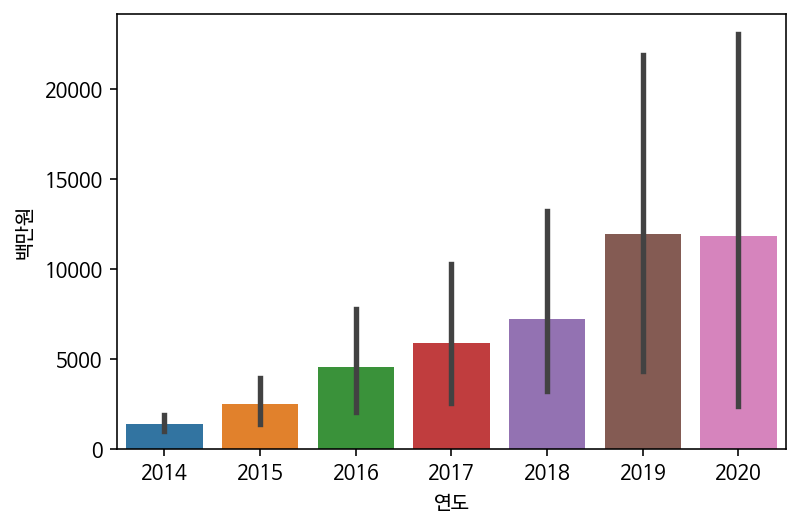

In [ ]:
sns.barplot(data=df_total, x='연도', y='백만원') # y축은 평균값을 나타내줌(estimator=<function meat at)
# 선 막대기로 신뢰구간의 차이가 큼을 볼 수있음

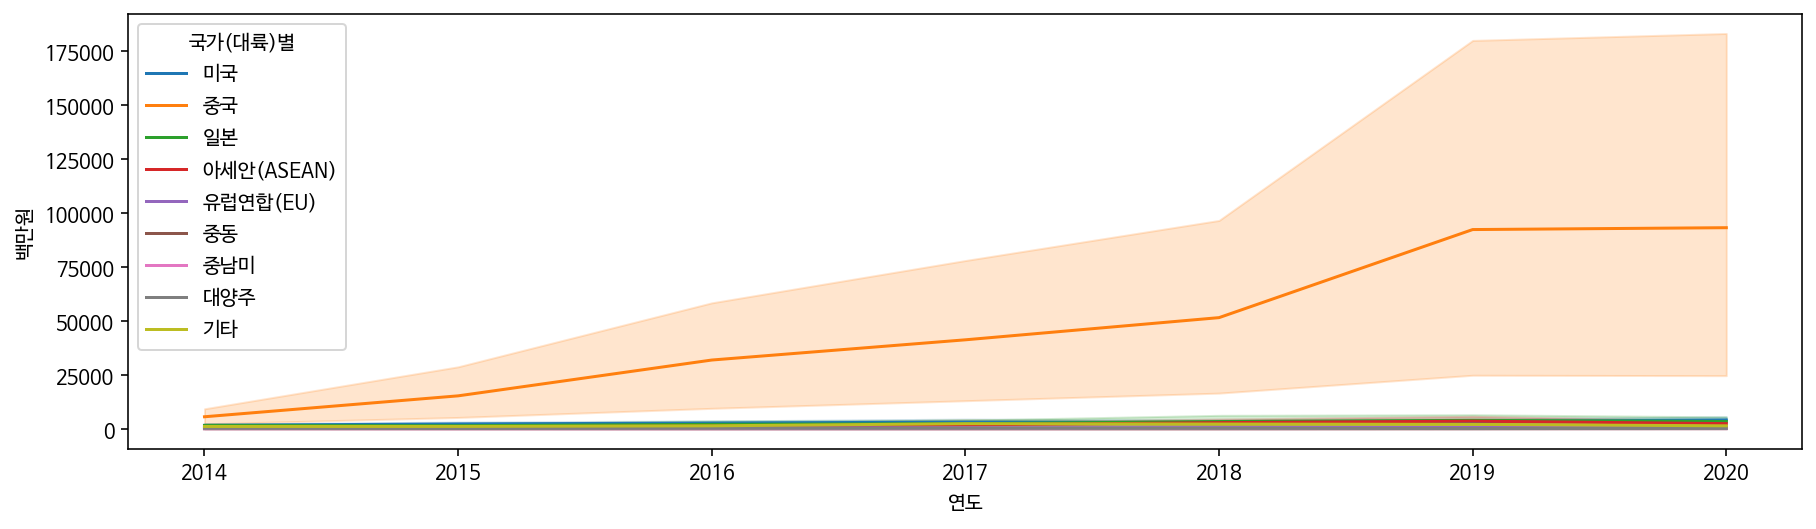

In [ ]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df_total, x='연도', y='백만원', hue='국가(대륙)별')

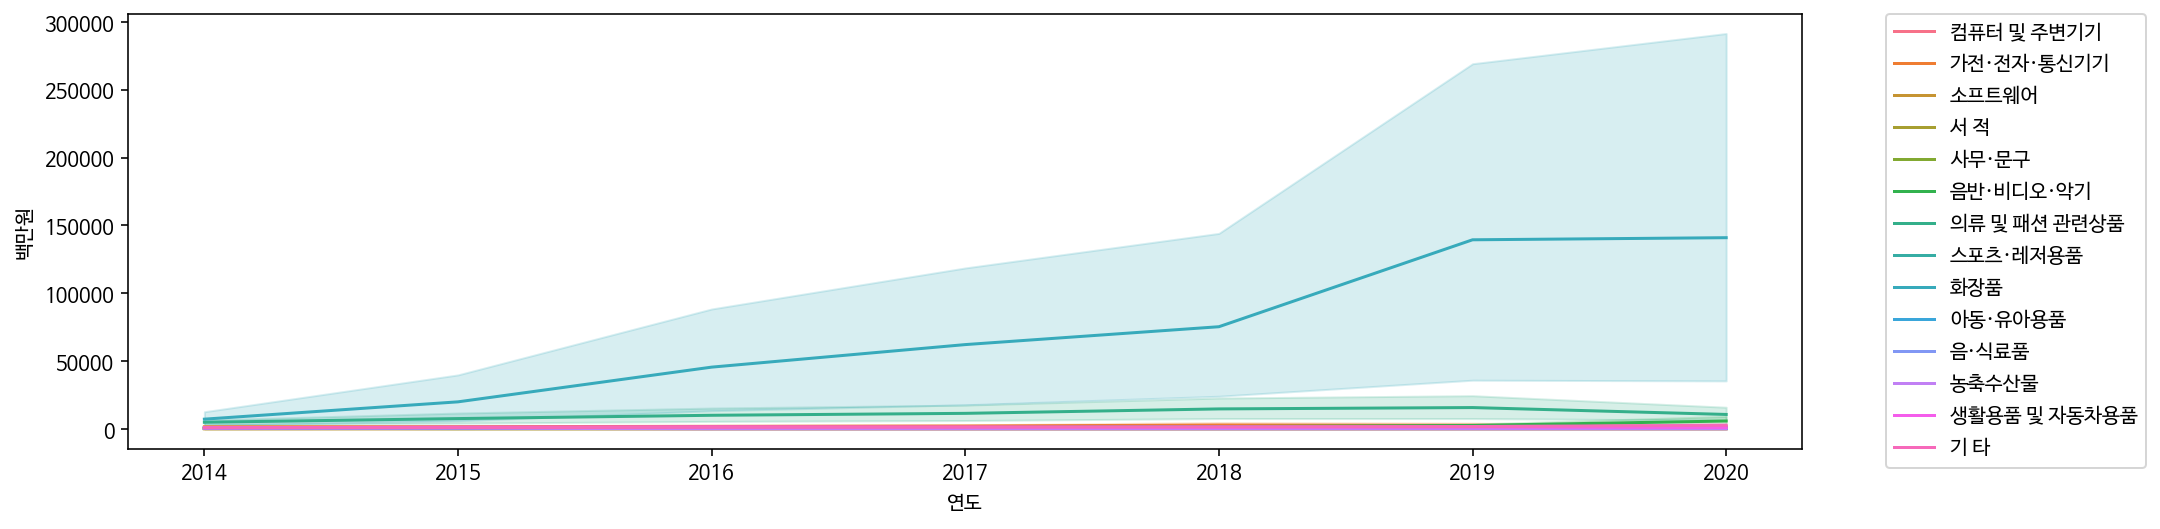

In [ ]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df_total, x='연도', y='백만원', hue='상품군별')
# legend를 밖으로 옮기는 코드를 아래 작성해줌
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# 기사에서는 2018년도 대비 2019년도에 온라인쇼핑 이 18% 증가했다고 하는데
# 위 그래프를 보면 데이터상 사실로 파악된다!!